## Prepared for the textbook:
-------------------------------------------------------------------
## Data Analysis for Business, Economics, and Policy
#### by Gabor BEKES and  Gabor KEZDI 
----------------------------------
#### Cambridge University Press 2021
-----------------------------------------------------------------------------------------------
#### License: Free to share, modify and use for educational purposes. Not to be used for business purposes.


In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/australia-weather-forecasts/clean"
data_out = dirname + "da_case_studies/ch11-australia-rainfall-predict/"
output = dirname + "da_case_studies/ch11-australia-rainfall-predict/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
data = pd.read_csv(os.path.join(data_in, "rainfall_australia.csv"))
data = data.loc[
    (data["station_name"] == "DARWIN AIRPORT") & (data["bd_FC_Before_Start"] == 39)
].reset_index(drop=True)

In [5]:
data["rain_prob_fc"] = data["prob"] / 100

In [6]:
def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[1], size=0.6, show_legend=True)
        + geom_point(
            color=color[1],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[2],
            size=0.3,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1, 0.1)))
    )

    return plot

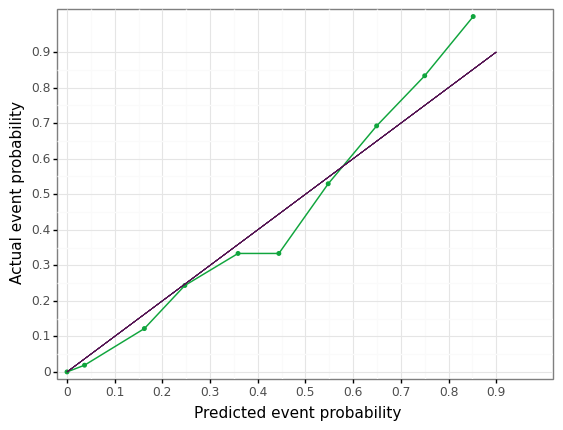

<ggplot: (305203902)>

In [7]:
create_calibration_plot(
    data,
    file_name="ch11-figure-6-weather-calib",
    prob_var="rain_prob_fc",
    actual_var="daily_sum",
    breaks=np.array([0, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
)

In [8]:
data["rain_prob_fc"].describe()

count    350.000000
mean       0.214600
std        0.230993
min        0.000000
25%        0.010000
50%        0.145000
75%        0.360000
max        0.880000
Name: rain_prob_fc, dtype: float64